In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mzsql import *
import sqlite3
import os

## Setup things

Create parquet, duckdb, and sqlite databases

In [2]:
if(not(os.path.exists("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite"))):
    turn_mzml_sqlite("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.mzML", "E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite")
    turn_mzml_duckdb("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.mzML", "E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.duckdb")
    turn_mzml_parquet("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.mzML", "E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01_pqds")

Identify the masses, rts, and scans that we'll be querying

In [3]:
conn = sqlite3.connect("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite")

In [4]:
rand_scan_query = """
SELECT id 
FROM (SELECT DISTINCT id FROM {0}) 
ORDER BY RANDOM() 
LIMIT 10
"""
rand_MS1_scans = pd.read_sql_query(rand_scan_query.format("MS1"), conn)["id"].tolist()
rand_MS2_scans = pd.read_sql_query(rand_scan_query.format("MS2"), conn)["id"].tolist()

In [5]:
top_int_df = pd.read_sql_query("SELECT * FROM MS1 ORDER BY int DESC LIMIT 30000", conn)
top_masses = []
top_rts = []
for i in range(10):
    top_rts.append(top_int_df["rt"].iloc[0])
    top_mz = top_int_df["mz"].iloc[0]
    top_masses.append(top_mz)
    mzmin, mzmax = pmppm(top_mz, 10)
    rtmin, rtmax = top_int_df["rt"].iloc[0]+(-1, 1)
    top_int_df = top_int_df[((top_int_df["mz"]<mzmin) | (top_int_df["mz"]>mzmax)) & ((top_int_df["rt"]<rtmin) | (top_int_df["rt"]>rtmax))]

In [6]:
top_fragments = []
top_frag_df = pd.read_sql_query("SELECT * FROM MS2 ORDER BY int DESC LIMIT 1000", conn)
for i in range(10):
    top_frag = top_frag_df["fragmz"].iloc[0]
    top_fragments.append(top_frag)
    mzmin, mzmax = pmppm(top_frag, 10)
    top_frag_df = top_frag_df[((top_frag_df["fragmz"]<mzmin) | (top_frag_df["fragmz"]>mzmax))]

top_precursors = []
top_frag_df = pd.read_sql_query("SELECT * FROM MS2 ORDER BY int DESC LIMIT 1000", conn)
for i in range(10):
    top_frag = top_frag_df["premz"].iloc[0]
    top_precursors.append(top_frag)
    mzmin, mzmax = pmppm(top_frag, 10)
    top_frag_df = top_frag_df[((top_frag_df["premz"]<mzmin) | (top_frag_df["premz"]>mzmax))]

In [7]:
pd.DataFrame({"MS1_scan":rand_MS1_scans, "MS2_scans":rand_MS2_scans, 
              "mz":top_masses, "rt":top_rts,
              "premz": top_precursors, "fragmz": top_fragments})

,MS1_scan,MS2_scans,mz,rt,premz,fragmz
0,8946,1886,829.797302,11.545580,752.606335,184.073044
1,8622,3826,663.452454,7.041390,827.694897,570.546631
2,11038,1163,647.457886,8.204955,753.613049,143.015900
3,3769,1461,529.398804,3.793528,700.625501,523.471558
4,9933,4085,338.341309,5.217645,829.797986,571.549805
5,8991,1014,1055.298584,10.213208,828.796887,55.017986
6,2862,3256,237.079178,2.777048,737.641003,237.078873
7,5887,997,215.059631,1.044877,683.598950,104.106827
8,9108,3325,664.459229,16.043565,738.646375,495.265289
9,8822,1776,648.462891,9.210695,235.169034,115.020996


## Confirm the subsets look ok

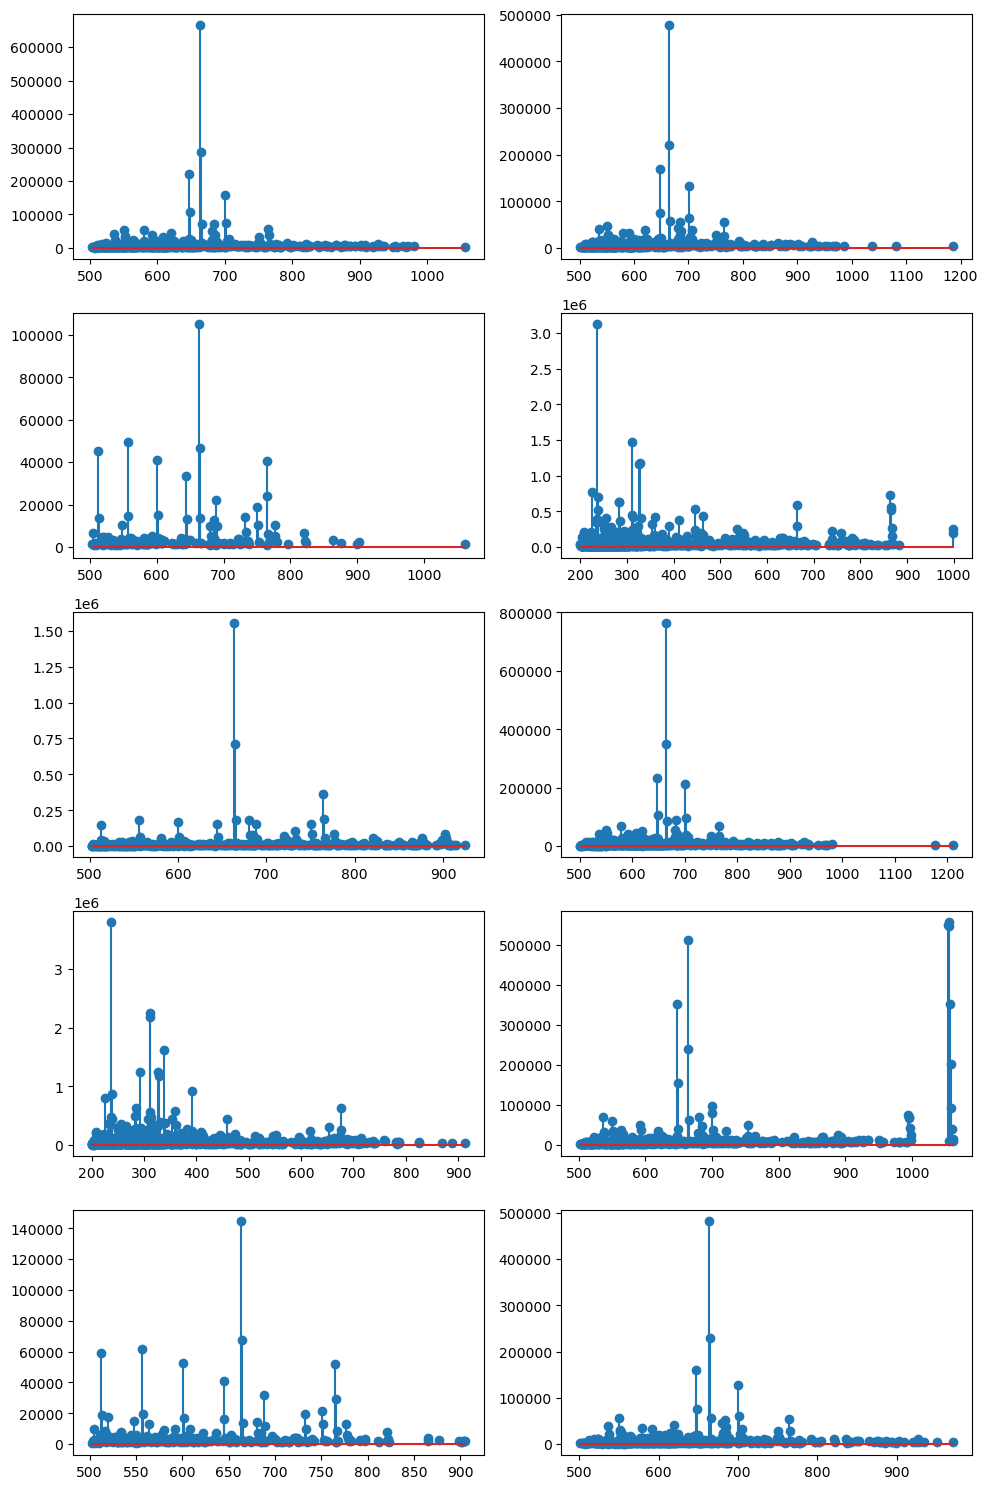

In [8]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    data_sub = get_spec_sqlite("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite", rand_MS1_scans[i])
    ax.stem(data_sub["mz"], data_sub["int"])
plt.tight_layout()

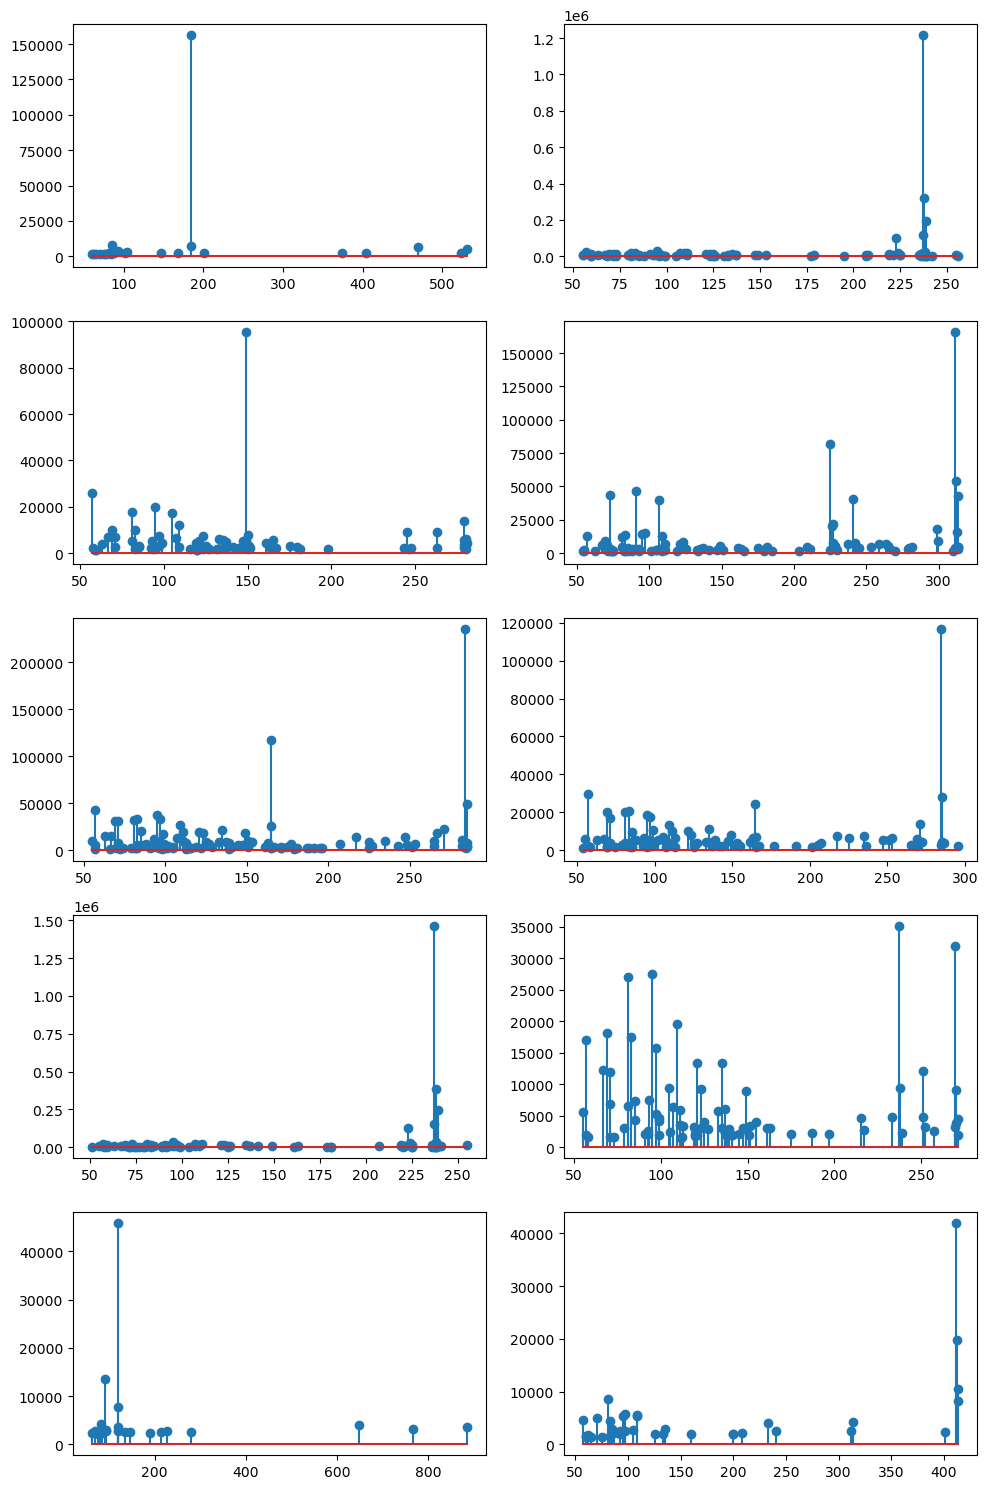

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    data_sub = get_spec_sqlite("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite", rand_MS2_scans[i])
    ax.stem(data_sub["mz"], data_sub["int"])
plt.tight_layout()

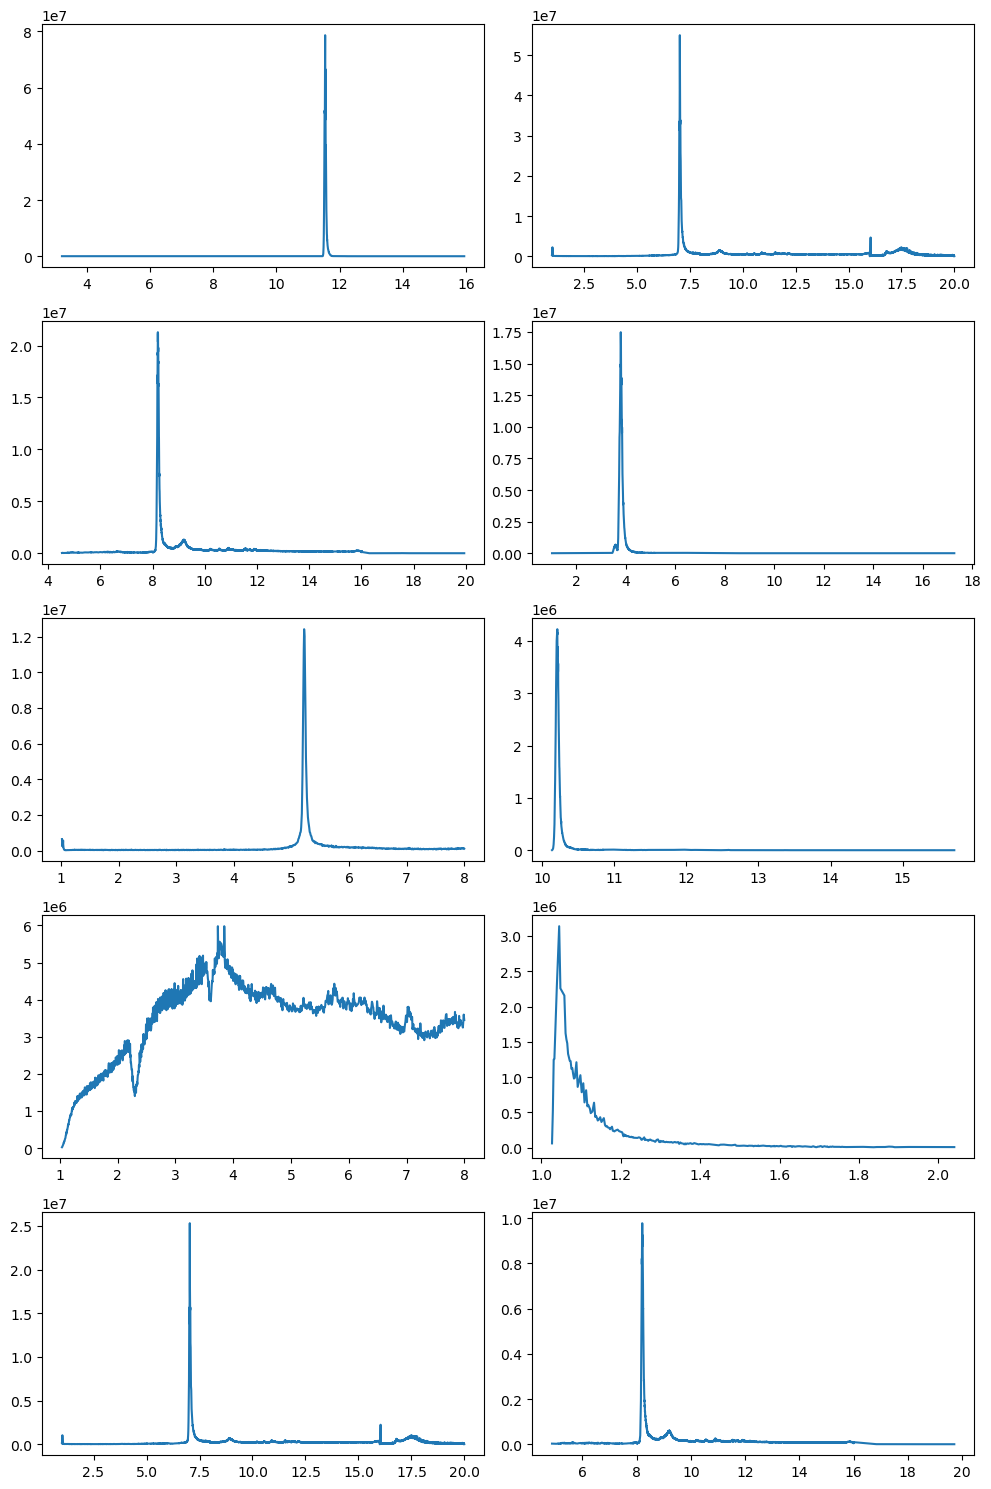

In [10]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    data_sub = get_chrom_sqlite("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite", top_masses[i], 10)
    ax.plot(data_sub["rt"], data_sub["int"])
plt.tight_layout()

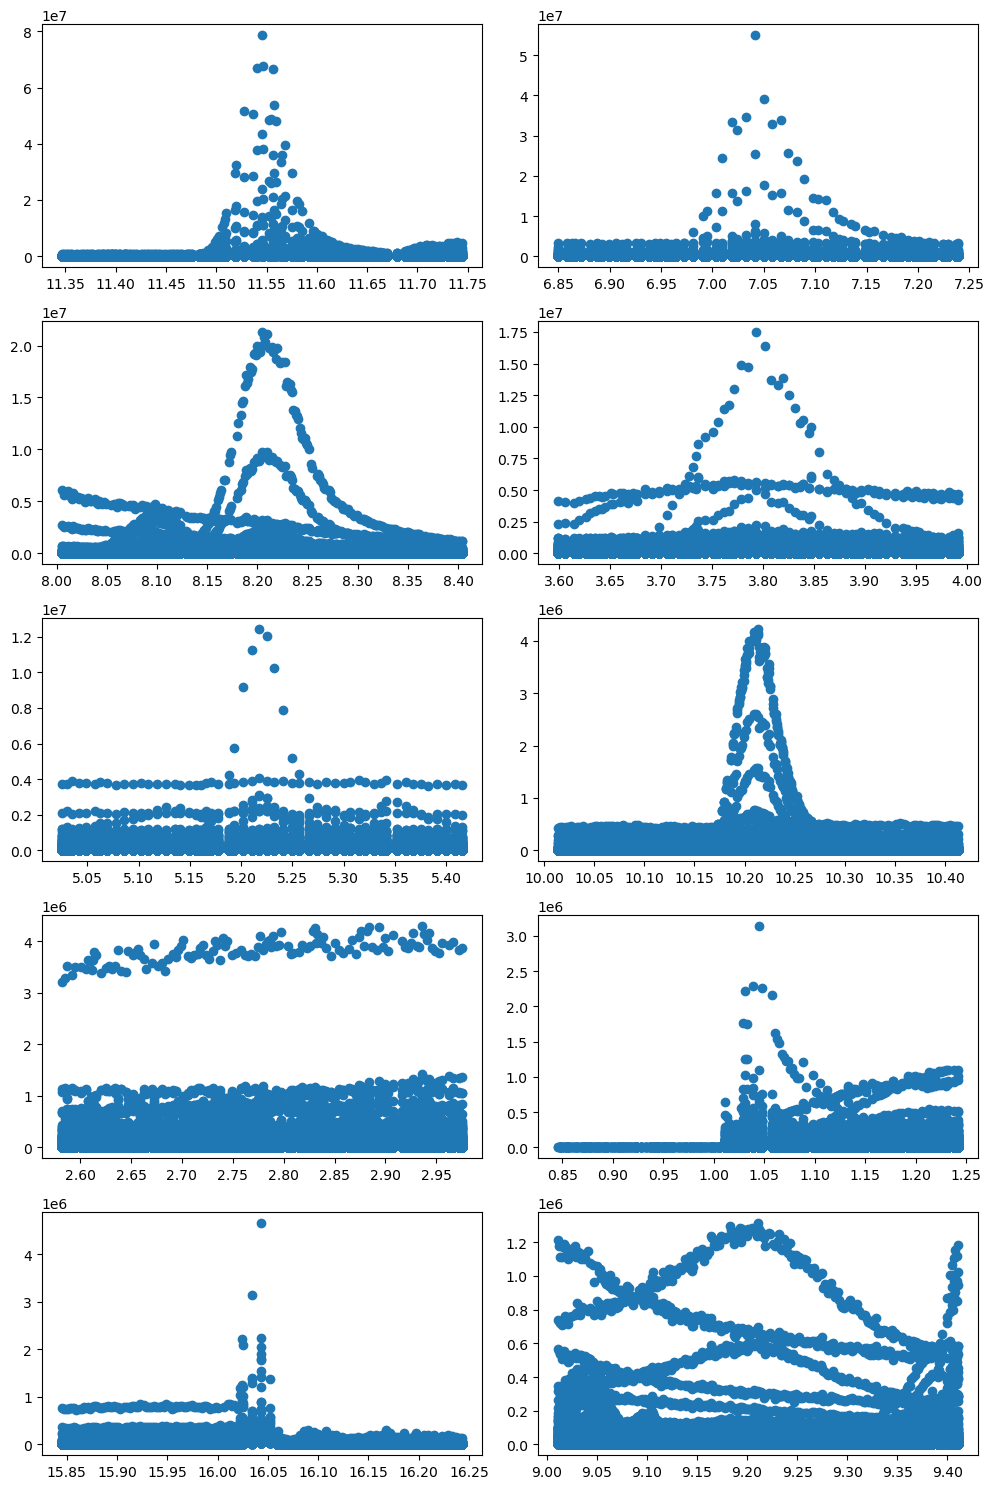

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    data_sub = get_rtrange_sqlite("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite", top_rts[i]-0.2, top_rts[i]+0.2)
    ax.scatter(data_sub["rt"], data_sub["int"])
plt.tight_layout()

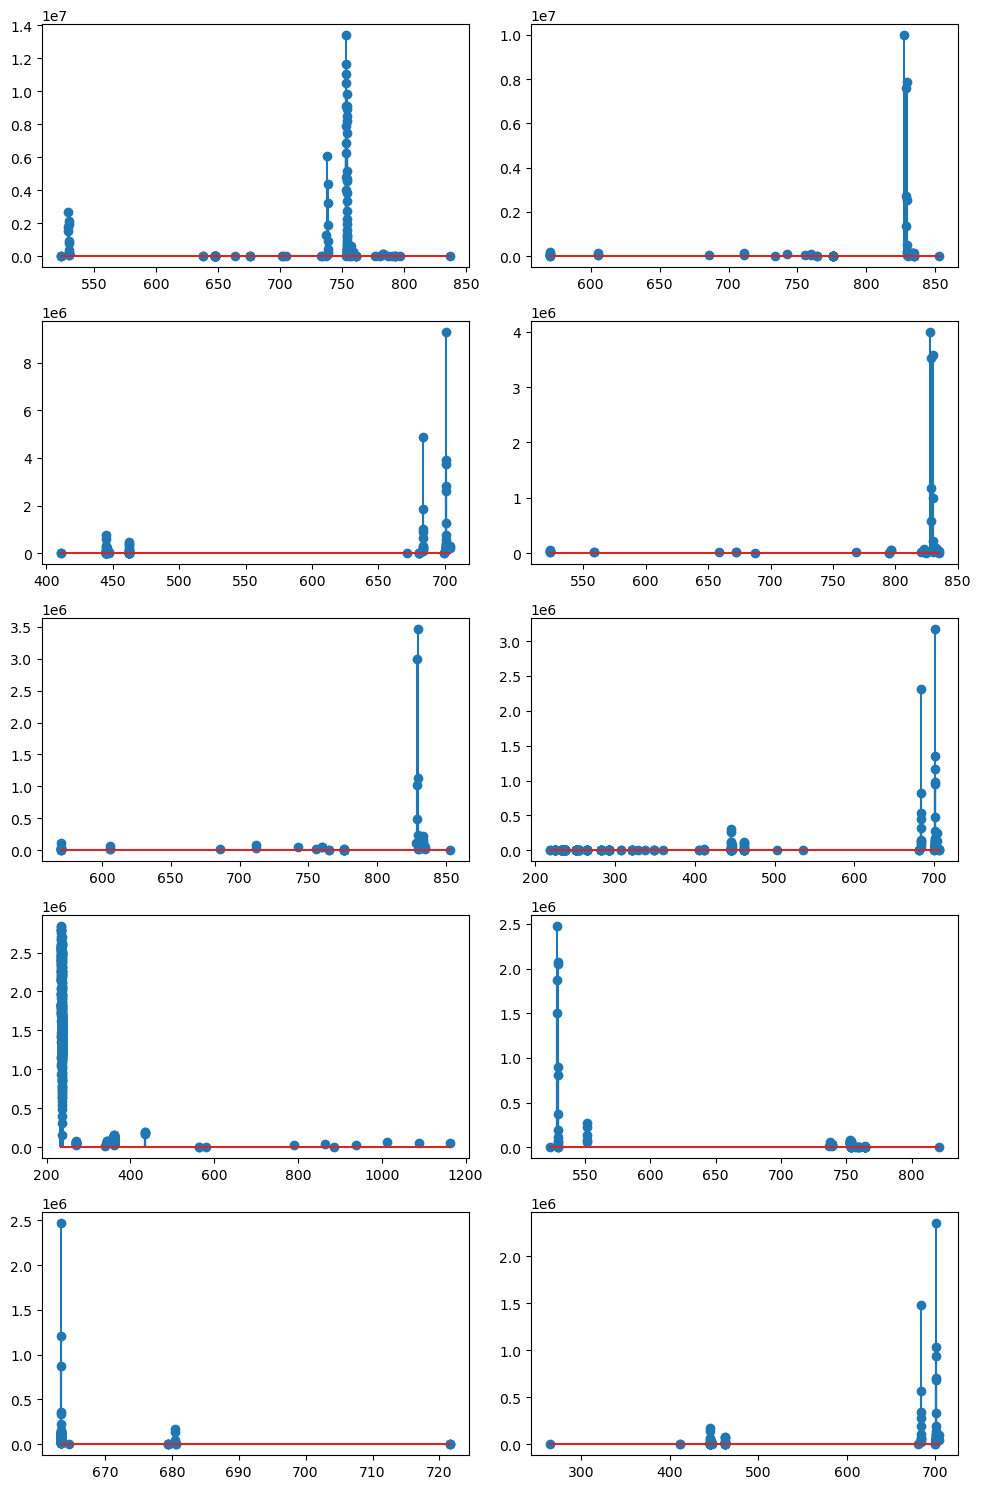

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    data_sub = get_MS2fragmz_sqlite("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite", top_fragments[i], 10)
    ax.stem(data_sub["premz"], data_sub["int"])
plt.tight_layout()

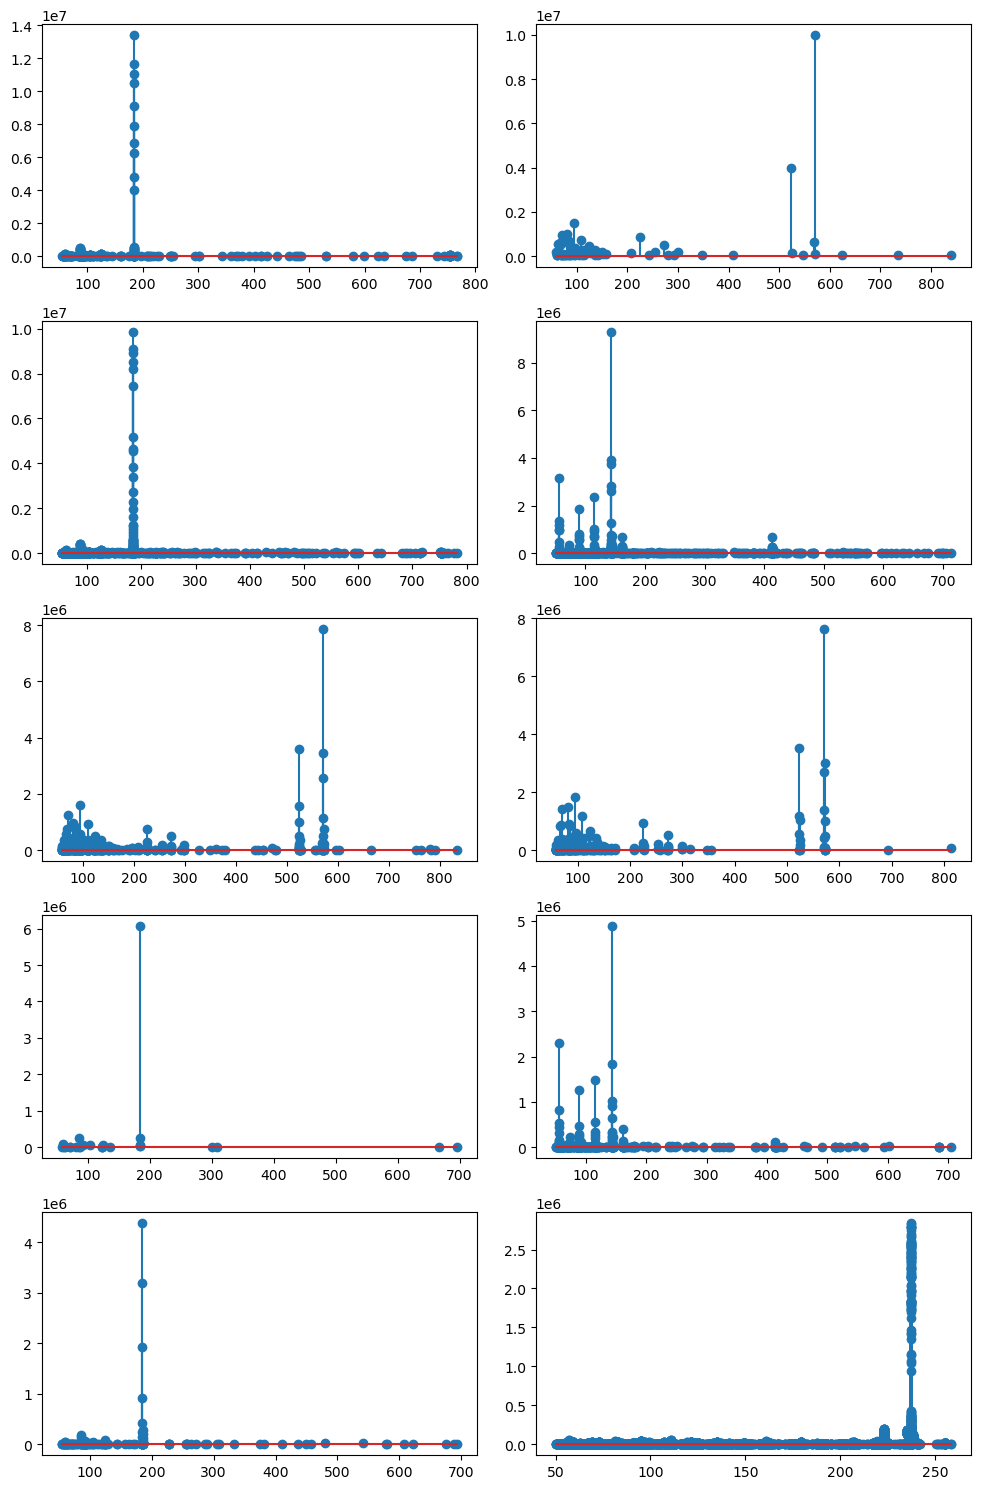

In [13]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    data_sub = get_MS2premz_sqlite("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.sqlite", top_precursors[i], 10)
    ax.stem(data_sub["fragmz"], data_sub["int"])
plt.tight_layout()

## Confirmation all plots return the same thing

In [14]:
isinstance("E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.mzML", str)

True

In [15]:
get_spec_mzml_pyopenms(["E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01.mzML"], 1)

,mz,int
0,218.743439,1309.692017
1,222.901825,1175.400513
2,321.746124,1268.662964
3,333.720612,1320.904053


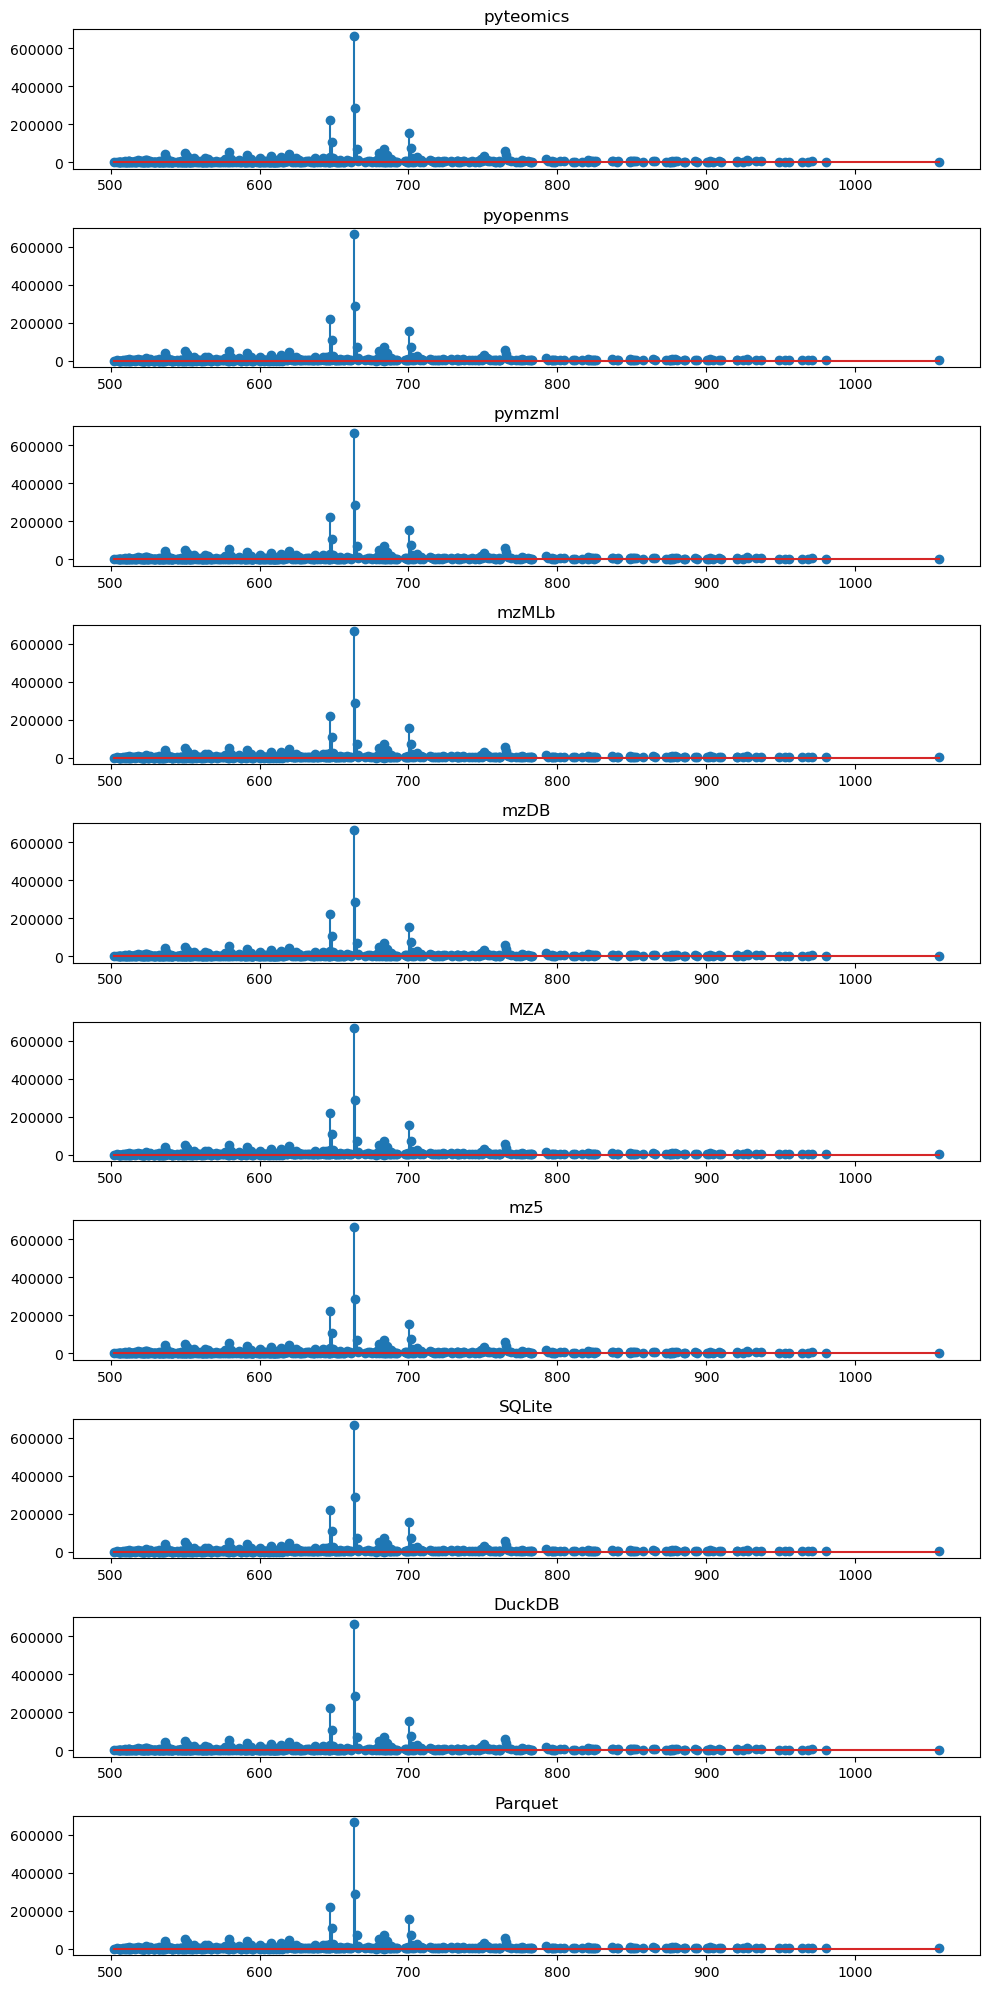

In [16]:
spec_functions = [
    ("pyteomics", "mzml_pyteomics", ".mzML"),
    ("pyopenms", "mzml_pyopenms", ".mzML"),
    ("pymzml", "mzml_pymzml", ".mzML"),
    ("mzMLb", "mzmlb", ".mzMLb"),
    ("mzDB", "mzdb", ".raw.mzDB"),
    ("MZA", "mza", ".mza"),
    ("mz5", "mz5", ".mz5"),
    ("SQLite", "sqlite", ".sqlite"),
    ("DuckDB", "duckdb", ".duckdb"),
    ("Parquet", "parquet", "_pqds")
]

fig, axes = plt.subplots(len(spec_functions), 1, figsize=(10, 2 * len(spec_functions)))
for ax, (name, suffix, file_ending) in zip(axes.flat, spec_functions):
    func_name = f"get_spec_{suffix}"
    file_path = f"E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01{file_ending}"
    data = globals()[func_name](file_path, rand_MS1_scans[0])
    ax.stem(data["mz"], data["int"])
    ax.set_title(name)
plt.tight_layout()

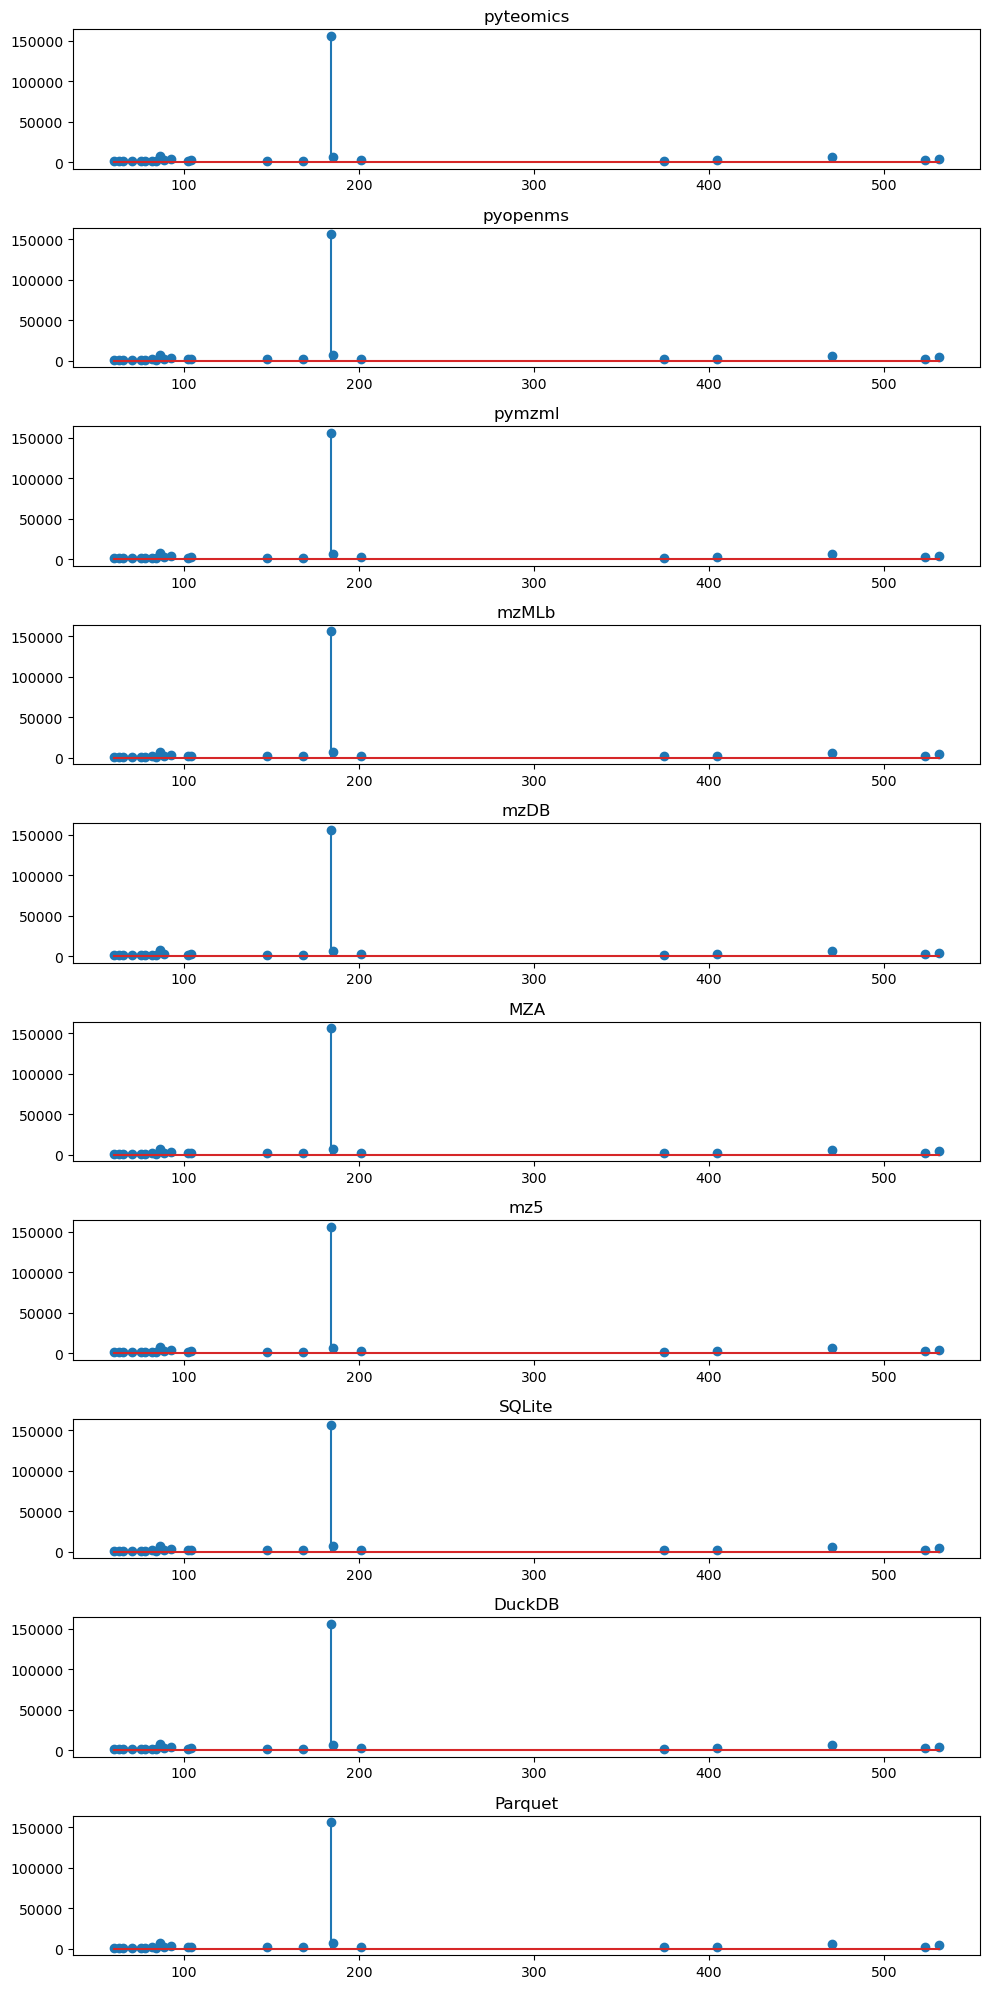

In [17]:
fig, axes = plt.subplots(len(spec_functions), 1, figsize=(10, 2 * len(spec_functions)))
for ax, (name, suffix, file_ending) in zip(axes.flat, spec_functions):
    func_name = f"get_spec_{suffix}"
    file_path = f"E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01{file_ending}"
    data = globals()[func_name](file_path, rand_MS2_scans[0])
    ax.stem(data["mz"], data["int"])
    ax.set_title(name)
plt.tight_layout()

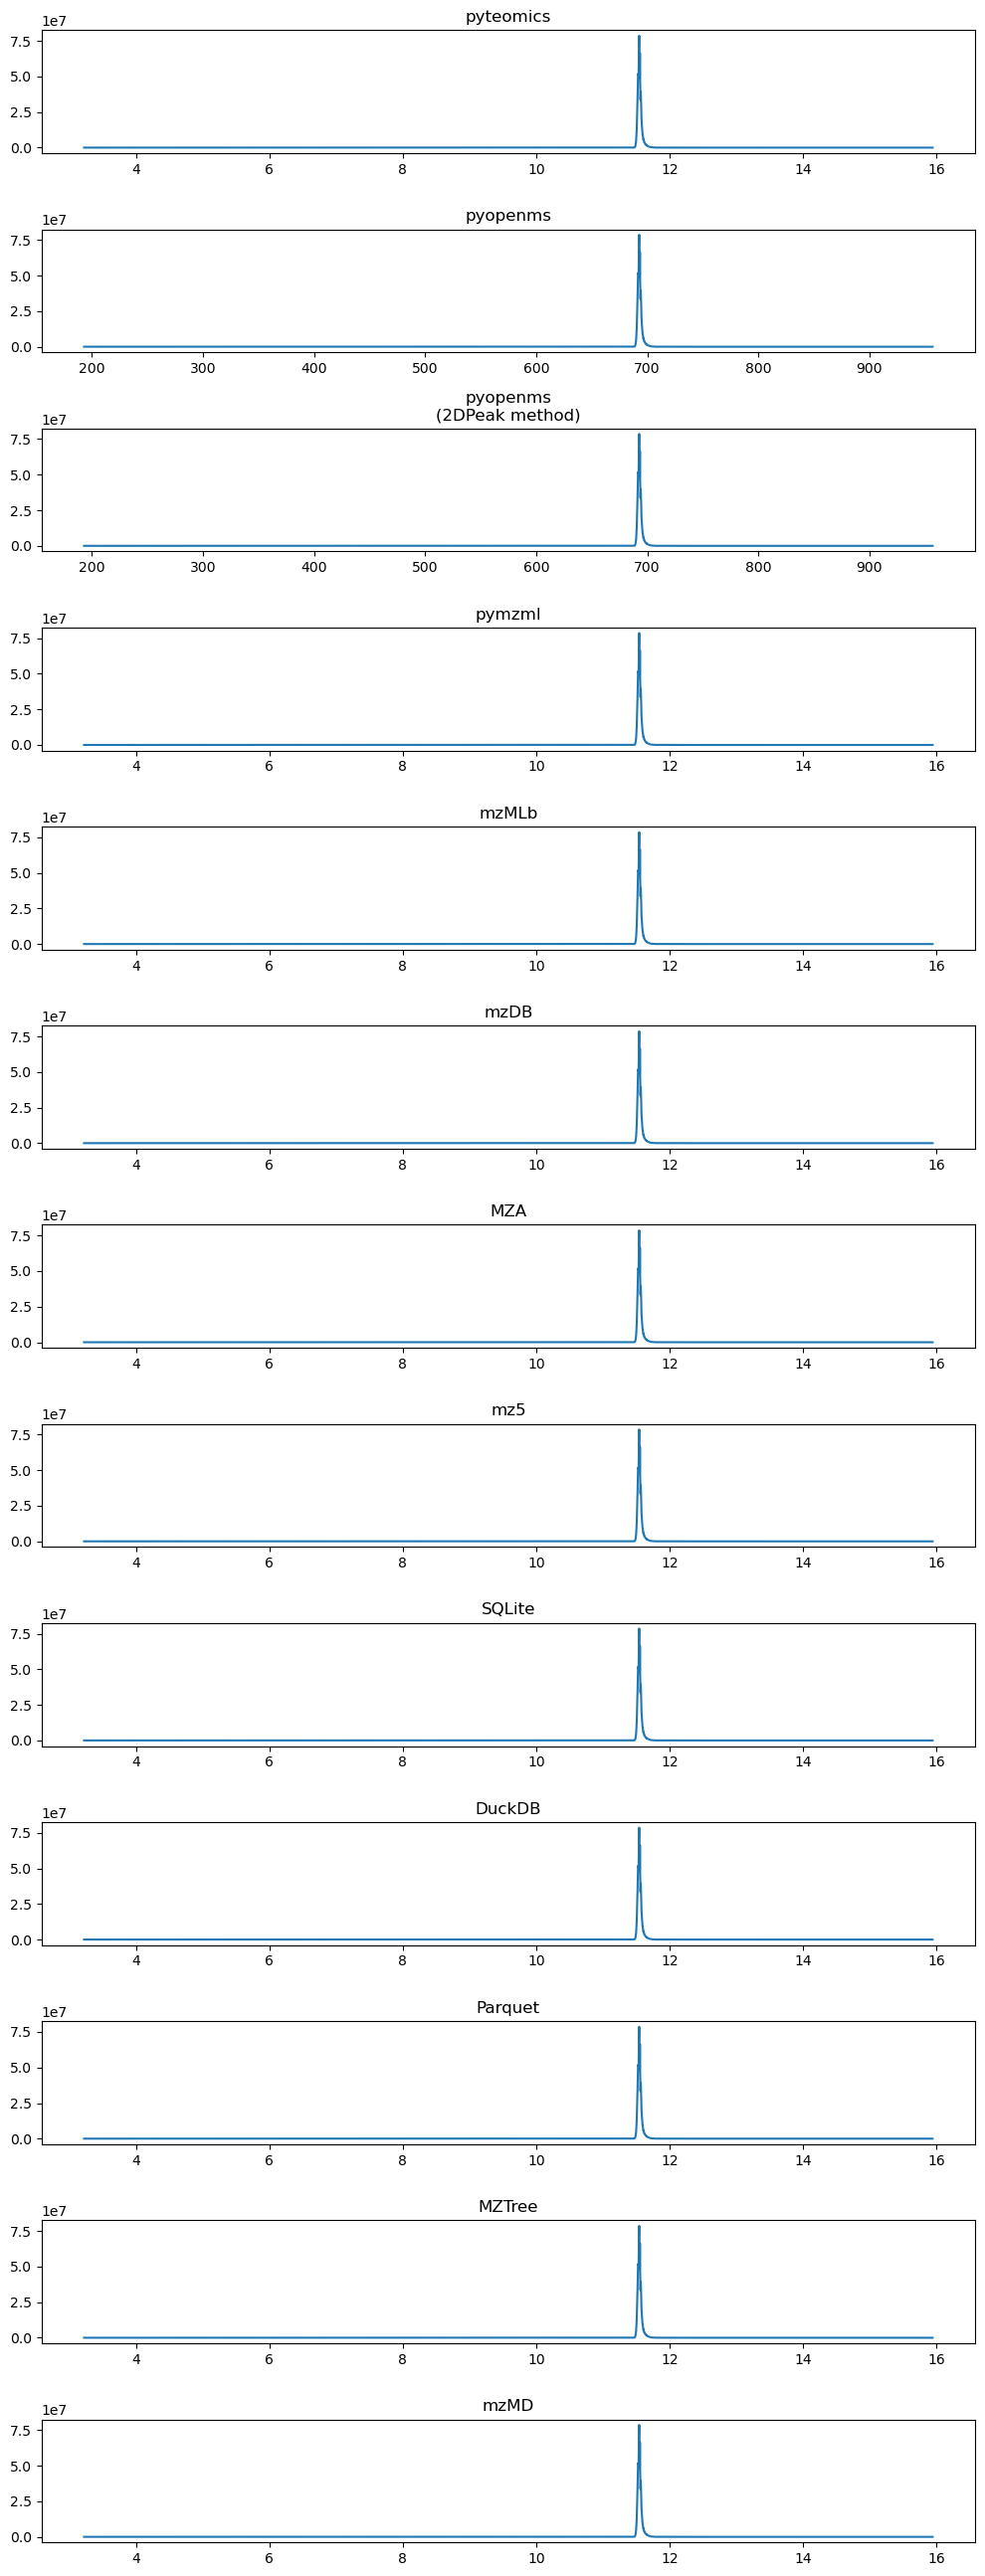

In [18]:
ms1_functions = [
    ("pyteomics", "mzml_pyteomics", ".mzML"),
    ("pyopenms", "mzml_pyopenms", ".mzML"),
    ("pyopenms\n(2DPeak method)", "mzml_pyopenms_2DPeak", ".mzML"),
    ("pymzml", "mzml_pymzml", ".mzML"),
    ("mzMLb", "mzmlb", ".mzMLb"),
    ("mzDB", "mzdb", ".raw.mzDB"),
    ("MZA", "mza", ".mza"),
    ("mz5", "mz5", ".mz5"),
    ("SQLite", "sqlite", ".sqlite"),
    ("DuckDB", "duckdb", ".duckdb"),
    ("Parquet", "parquet", "_pqds"),
    ("MZTree", "mztree", "http://127.0.0.1:4568"),
    ("mzMD", "mzMD", "http://127.0.0.1:4567")
]

fig, axes = plt.subplots(len(ms1_functions), 1, figsize=(10, 2 * len(ms1_functions)))
for ax, (name, suffix, file_ending) in zip(axes.flat, ms1_functions):
    func_name = f"get_chrom_{suffix}"
    if suffix in ["mztree", "mzMD"]:
        data = globals()[func_name](file_ending, top_masses[0], 10)
    else:
        file_path = f"E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01{file_ending}"
        data = globals()[func_name](file_path, top_masses[0], 10)
    ax.plot(data["rt"], data["int"])
    ax.set_title(name)
plt.tight_layout()

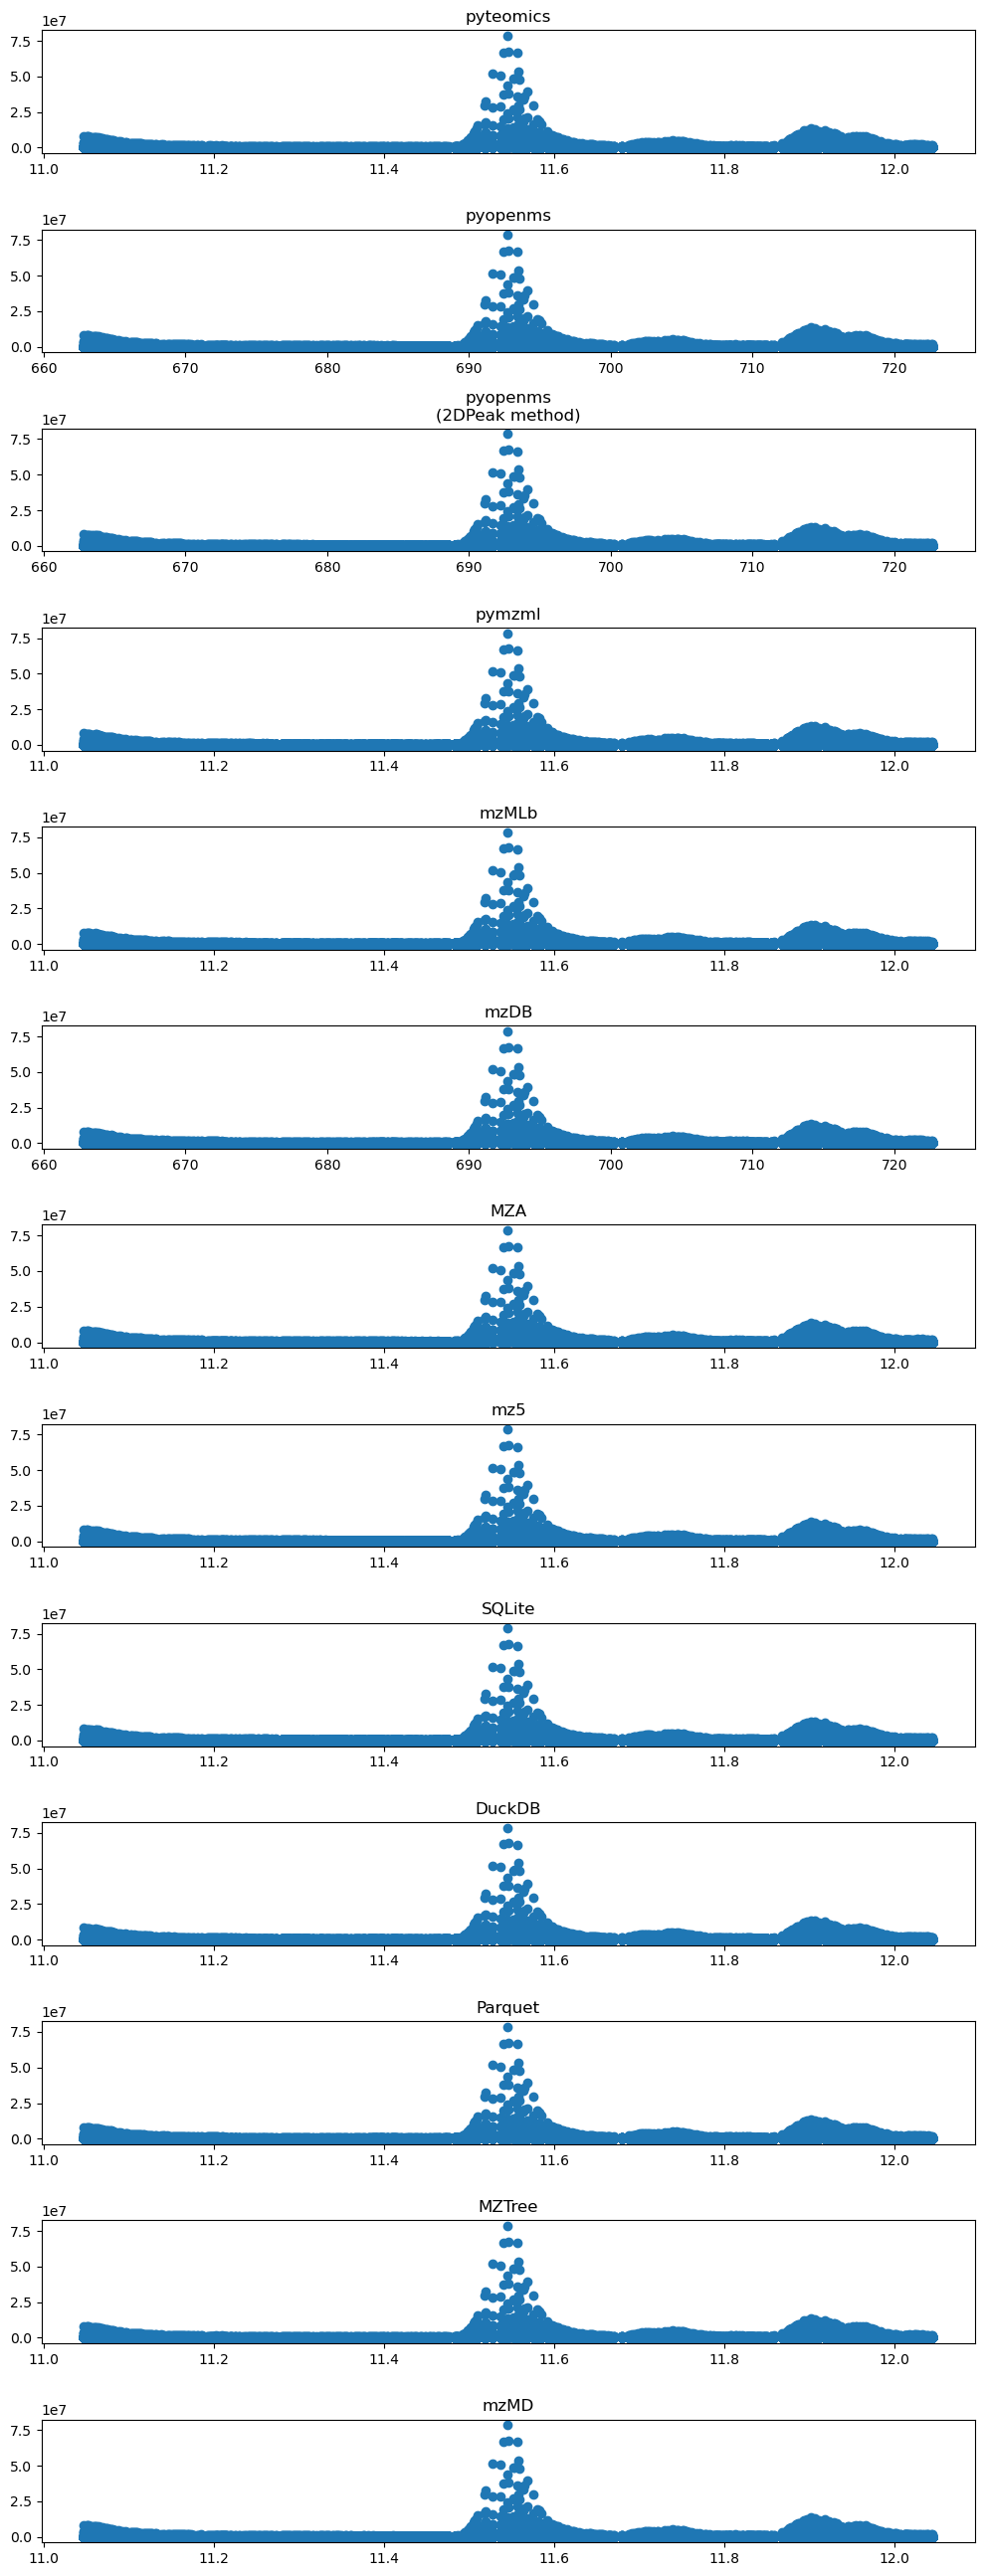

In [19]:
fig, axes = plt.subplots(len(ms1_functions), 1, figsize=(10, 2 * len(ms1_functions)))
for ax, (name, suffix, file_ending) in zip(axes.flat, ms1_functions):
    func_name = f"get_rtrange_{suffix}"
    if suffix in ["mztree", "mzMD"]:
        data = globals()[func_name](file_ending, top_rts[0]-0.5, top_rts[0]+0.5)
    else:
        file_path = f"E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01{file_ending}"
        data = globals()[func_name](file_path, top_rts[0]-0.5, top_rts[0]+0.5)
    ax.scatter(data["rt"], data["int"])
    ax.set_title(name)
plt.tight_layout()

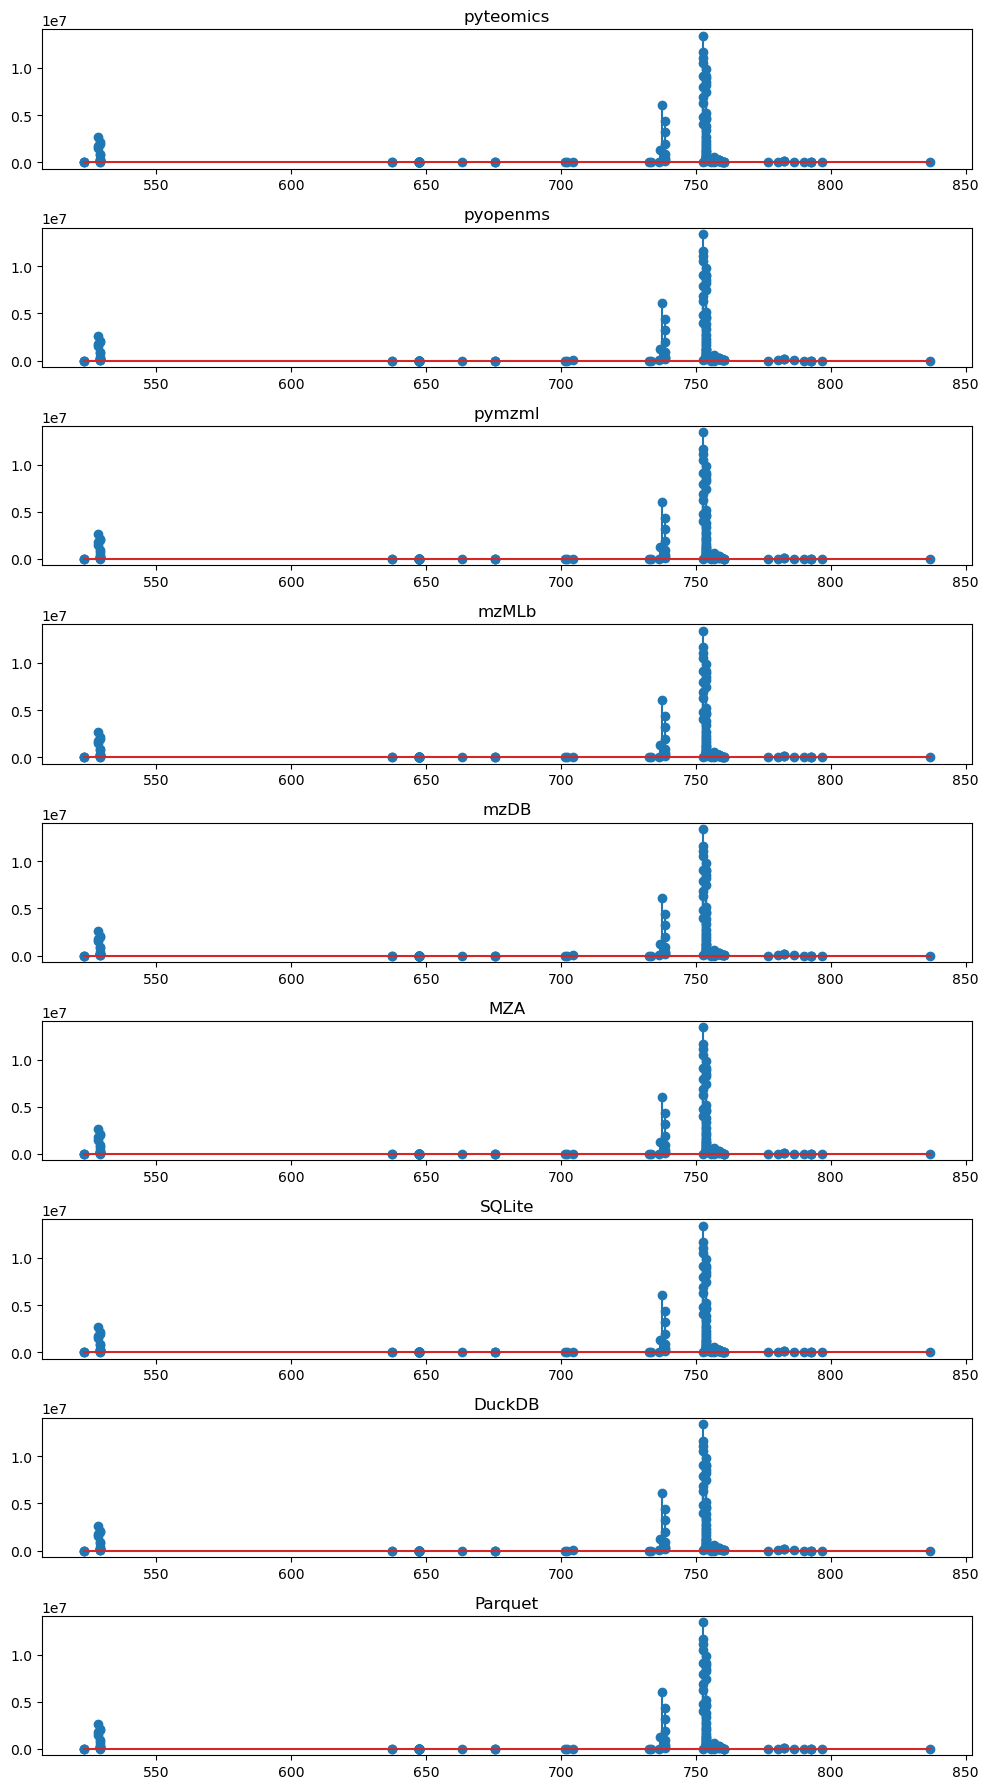

In [20]:
ms2_functions = [
    ("pyteomics", "mzml_pyteomics", ".mzML"),
    ("pyopenms", "mzml_pyopenms", ".mzML"),
    ("pymzml", "mzml_pymzml", ".mzML"),
    ("mzMLb", "mzmlb", ".mzMLb"),
    ("mzDB", "mzdb", ".raw.mzDB"),
    ("MZA", "mza", ".mza"),
    ("SQLite", "sqlite", ".sqlite"),
    ("DuckDB", "duckdb", ".duckdb"),
    ("Parquet", "parquet", "_pqds")
]

fig, axes = plt.subplots(len(ms2_functions), 1, figsize=(10, 2 * len(ms2_functions)))
for ax, (name, suffix, file_ending) in zip(axes.flat, ms2_functions):
    func_name = f"get_MS2fragmz_{suffix}"
    file_path = f"E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01{file_ending}"
    data = globals()[func_name](file_path, top_fragments[0], 10)
    ax.stem(data["premz"], data["int"])
    ax.set_title(name)
plt.tight_layout()

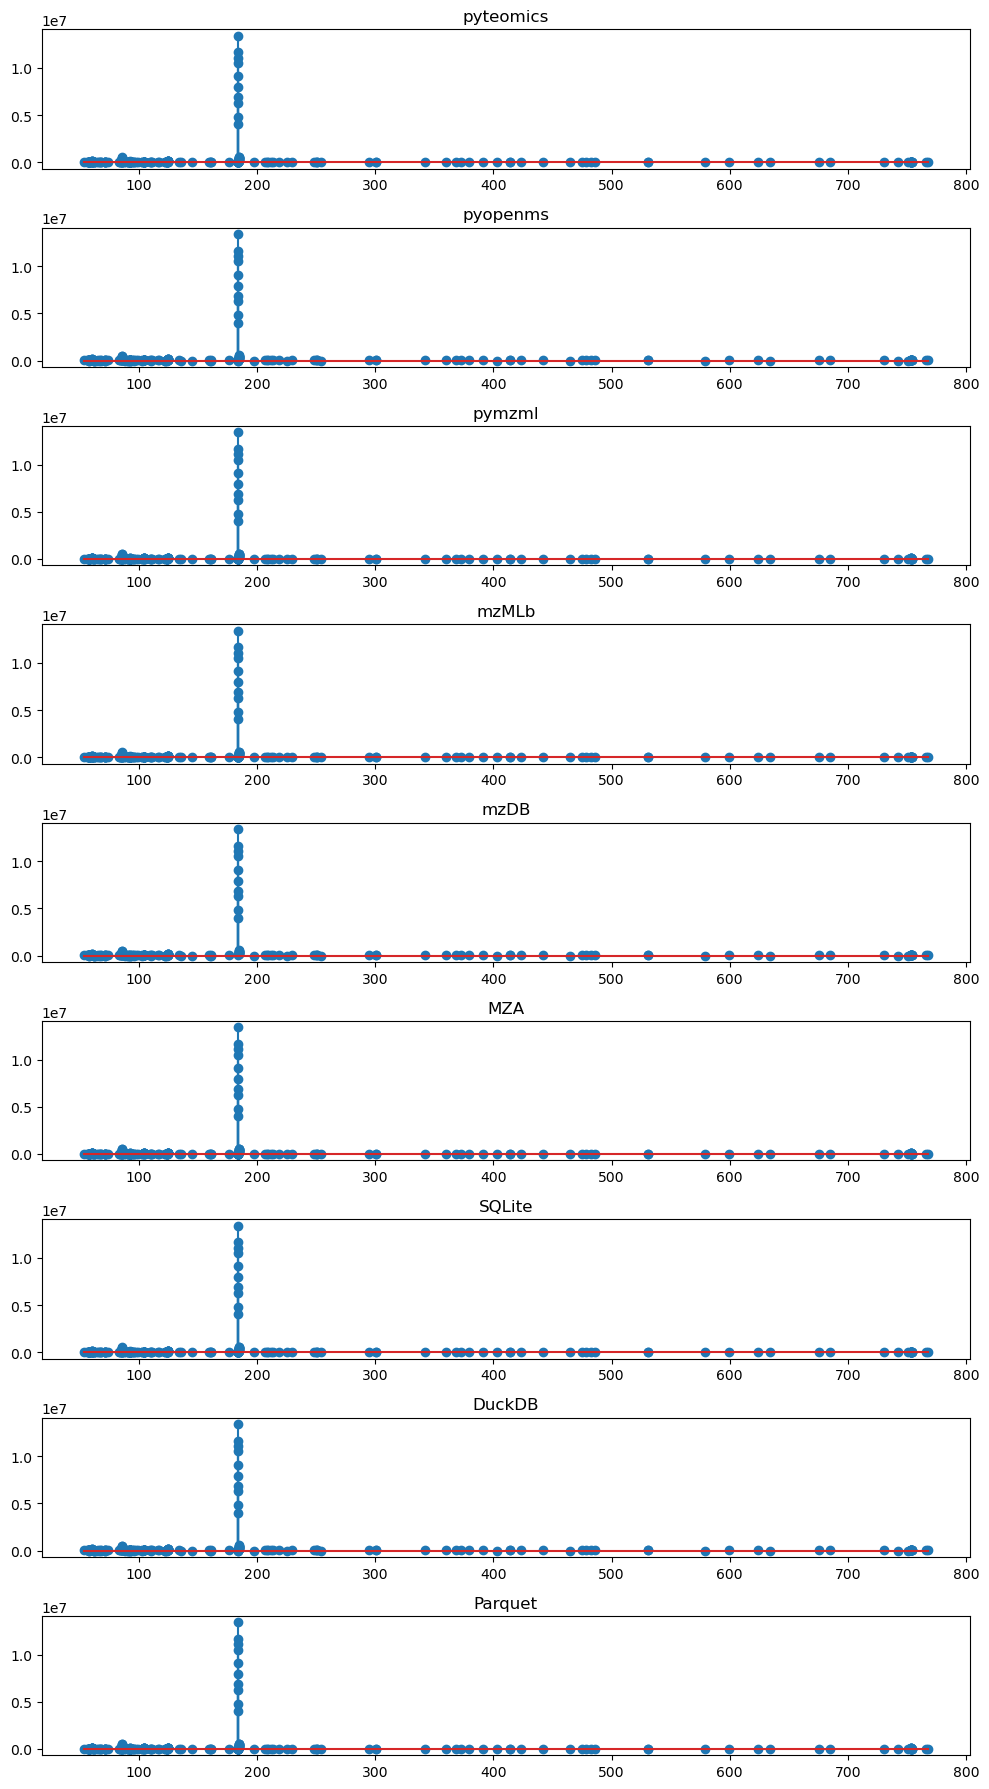

In [21]:
fig, axes = plt.subplots(len(ms2_functions), 1, figsize=(10, 2 * len(ms2_functions)))
for ax, (name, suffix, file_ending) in zip(axes.flat, ms2_functions):
    func_name = f"get_MS2premz_{suffix}"
    file_path = f"E:/mzsql/MTBLS10066/20220921_LEAP-POS_BL01{file_ending}"
    data = globals()[func_name](file_path, top_precursors[0], 10)
    ax.stem(data["fragmz"], data["int"])
    ax.set_title(name)
plt.tight_layout()